# End-to-End Machine Learning Model using PySpark and MLlib (2)
#### Binary Classification

Machine learning in the real world is messy. Data sources contain missing values, include redundant rows, or may not fit in memory. Feature engineering often requires domain expertise and can be tedious. Modeling too often mixes data science and systems engineering, requiring not only knowledge of algorithms but also of machine architecture and distributed systems.

In this notebook, we build a model to predict the **quality of Portugese "Vinho Verde" wine** based on the wine's physicochemical properties.

This tutorial covers the following steps:

- Import data from your local machine into the Databricks File System (DBFS)
- Visualize the data using Seaborn and matplotlib
- Run a parallel hyperparameter sweep to train machine learning models on the dataset
- Explore the results of the hyperparameter sweep with MLflow
- Register the best performing model in MLflow
- Apply the registered model to another dataset using a Spark UDF

In [5]:
#we use the findspark library to locate spark on our local machine
import findspark
findspark.init('C:/Users/bokhy/spark/spark-2.4.6-bin-hadoop2.7')

In [30]:
import os
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import time
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import pyspark # only run this after findspark.init()
from pyspark.sql import SparkSession, SQLContext
from pyspark.context import SparkContext
from pyspark.sql.functions import * 
from pyspark.sql.types import * 

## 1. Load Data 
This dataset is available as a public dataset from https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/ 

In [8]:
white_wine = pd.read_csv("./data/winequality-white.csv", sep=';')
red_wine = pd.read_csv("./data/winequality-red.csv", sep=';')

Merge the two DataFrames into a single dataset.

In [9]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0

data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [10]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


## 2. EDA

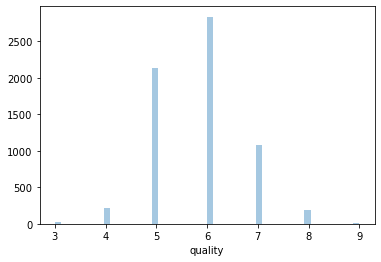

In [11]:
sns.distplot(data.quality, kde=False)

Looks like quality scores are normally distributed between 3 and 9.

Let's Define a wine as **high quality** if **quality >= 7**.

In [12]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

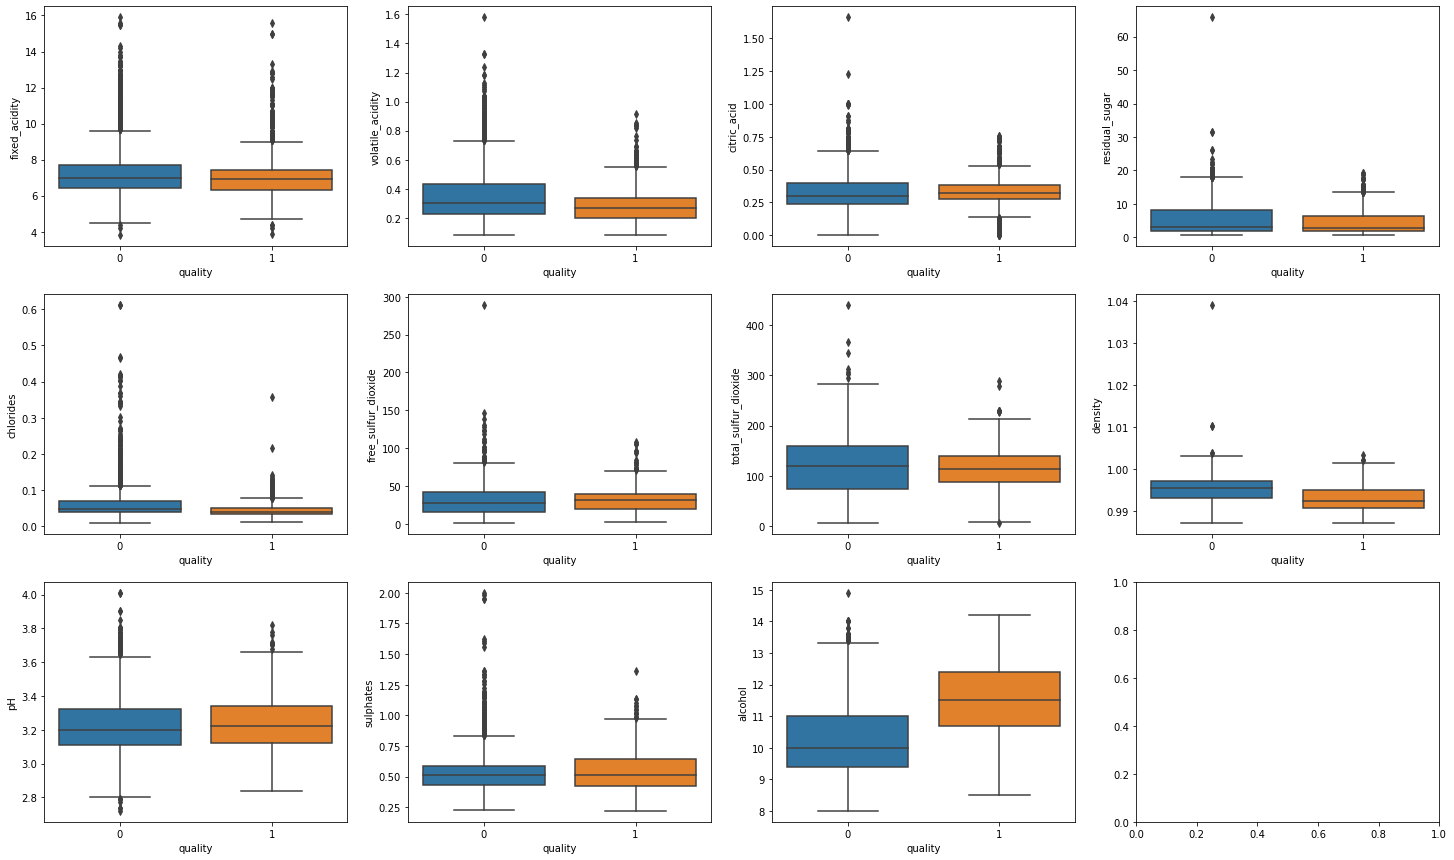

In [13]:
import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
    if col == 'is_red' or col == 'quality':
        continue # Box plots cannot be used on indicator variables
    sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
    axis_j += 1
    if axis_j == dims[1]:
        axis_i += 1
        axis_j = 0

A few variables look like good univariate predictors of quality:

- High alcohol content predicts high quality
- High density predicts low quality

In [14]:
# Chech any missing variables
data.isna().any()

fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
is_red                  False
dtype: bool

## 3. PreProcessing

#### Train/Test Split

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=623)
X_train = train.drop(["quality"], axis=1)
X_test = test.drop(["quality"], axis=1)
y_train = train.quality
y_test = test.quality

## 4. Create a Model

In [19]:
import mlflow

This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

Build a classifier using scikit-learn. It uses MLflow to keep track of the model accuracy, and to save the model for later use

In [20]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifacts

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        return self.model.predict_proba(model_input)[:,1]

# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
    n_estimators = 10
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
    model.fit(X_train, y_train)

    # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
    predictions_test = model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_param('n_estimators', n_estimators)
    
    # Use the area under the ROC curve as a metric
    mlflow.log_metric('auc', auc_score)
    wrappedModel = SklearnModelWrapper(model)
    mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel)

#### Examine the learned feature importances output by the model as a sanity-check.

In [22]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

,importance
alcohol,0.164451
density,0.122065
volatile_acidity,0.091452
pH,0.082677
total_sulfur_dioxide,0.081323
citric_acid,0.081240
sulphates,0.080782
free_sulfur_dioxide,0.078151
chlorides,0.075952
residual_sugar,0.075057


As illustrated by the boxplots shown previously, both **alcohol** and **density** are important in predicting quality.

Registering the model in the MLflow Model Registry
By registering this model in the Model Registry, you can easily reference the model from anywhere within Databricks.

The following section shows how to do this programmatically, but you can also register a model using the UI by following the steps in [Register a model in the Model Registry](https://docs.databricks.com/applications/mlflow/model-registry.html#register-a-model-in-the-model-registry).

In [23]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id

In [25]:
run_id

'ad2474369f2448b7bb603866c005b41d'

In [ ]:
mlflow.register_model(f"runs:/{run_id}/random_forest_model", "wine_quality")

You should now see the wine-quality model in the Models page. To display the Models page, click the Models icon in the left sidebar.

Next, transition this model to production and load it into this notebook from the model registry.

In [ ]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
  name="wine_quality",
  version=1,
  stage="Production"
)

The Models page now shows the model version in stage "Production".

You can now refer to the model using the path "models:/wine-quality/production".

In [ ]:
model = mlflow.pyfunc.load_model("models:/wine_quality/production")

# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

## 5. Experimenting with a new model

The random forest model performed well even without hyperparameter tuning.

The following code uses the xgboost library to train a more accurate model. It runs a parallel hyperparameter sweep to train multiple models in parallel, using Hyperopt and SparkTrials. As before, the code tracks the performance of each parameter configuration with MLflow.

In [ ]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb

search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'reg:squarederror',
  'seed': 123, # Set a seed for deterministic training
}

# With MLflow autologging, you don't need to explicitly log hyperparameters to MLflow. They are captured automatically.
mlflow.xgboost.autolog()

def train_model(params):
    train = xgb.DMatrix(data=X_train, label=y_train)
    test = xgb.DMatrix(data=X_test, label=y_test)
    # Pass in the test set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
    # is no longer improving.
    booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                          evals=[(test, "test")], early_stopping_rounds=50)
    predictions_test = booster.predict(test)
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_metric('auc', auc_score)

    # Log the model so you can later use it for inference
    mlflow.xgboost.log_model(booster, 'xgb_model')
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}

# A reasonable value for parallelism is the number of Spark workers on your cluster
spark_trials = SparkTrials(parallelism=8)

# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='xgboost_models'):
    best_params = fmin(
        fn=train_model, 
        space=search_space, 
        algo=tpe.suggest, 
        max_evals=96,
        trials=spark_trials, 
        rstate=np.random.RandomState(123)
  )

## 6. Use MLflow to view the results
Open up the Runs sidebar to see the MLflow runs. Click on Date next to the down arrow to display a menu, and select 'auc' to display the runs sorted by the auc metric. The highest auc value is 0.91. You beat the baseline!

MLflow tracks the parameters and performance metrics of each run. Click the External Link icon  at the top of the Runs Sidebar to navigate to the MLflow Runs Table.

Now investigate how the hyperparameter choice correlates with AUC. Click the "+" icon to expand the parent run, then select all runs except the parent, and click "Compare". Select the Parallel Coordinates Plot.

The Parallel Coordinates Plot is useful in understanding the impact of parameters on a metric. You can drag the pink slider bar at the upper right corner of the plot to highlight a subset of AUC values and the corresponding parameter values. The plot below highlights the highest AUC values:

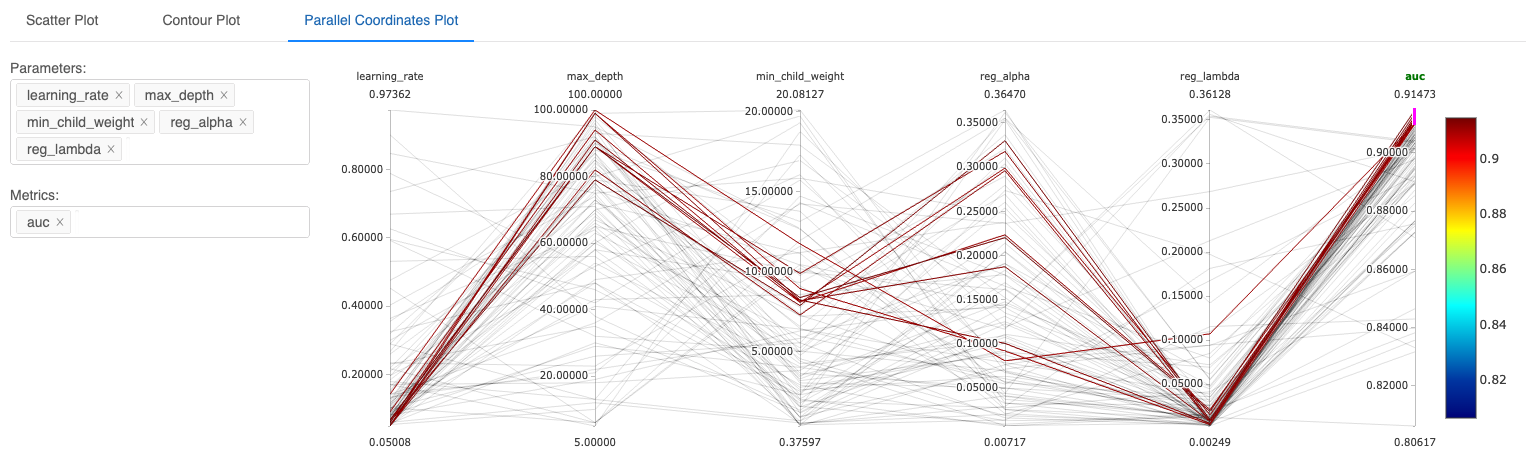

In [31]:
file_name1 = './img/parallel-coordinates-plot.png'
Image(file_name1)

Notice that all of the top performing runs have a low value for reg_lambda and learning_rate.

You could run another hyperparameter sweep to explore even lower values for these parameters. For simplicity, that step is not included in this example.

In [ ]:
# Get the best performing run and saves the model to the model registry.
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

## 7. Updating the production wine_quality model in the MLflow Model Registry
Earlier, you saved the baseline model to the Model Registry under "wine_quality". Now that you have a created a more accurate model, update wine_quality.

In [ ]:
mlflow.register_model(f"runs:/{best_run.run_id}/xgb_model", "wine_quality")

##### Promotes the new version to production.

In [ ]:
# Archive the old model version
client.transition_model_version_stage(
  name="wine_quality",
  version=1,
  stage="Archived",
)

# Promote the new model version to Production
client.transition_model_version_stage(
  name="wine_quality",
  version=2,
  stage="Production",
)

##### Clients that call load_model now receive the new model.

In [ ]:
model = mlflow.pyfunc.load_model("models:/wine_quality/production")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

## 8. Batch Inference
There are many scenarios where you might want to evaluate a model on a corpus of new data. For example, you may have a fresh batch of data, or may need to compare the performance of two models on the same corpus of data.

We evaluate the model on data stored in a Delta table, using Spark to run the computation in parallel.

In [ ]:
# To simulate a new corpus of data, save the existing X_train data to a Delta table. 
# In the real world, this would be a new batch of data.
spark_df = spark.createDataFrame(X_train)
# Replace <username> with your username before running this cell.
table_path = "dbfs:/<username>/delta/wine_data"
# Delete the contents of this path in case this cell has already been run
dbutils.fs.rm(table_path, True)
spark_df.write.format("delta").save(table_path)

Load the model into a Spark UDF, so it can be applied to the Delta table.

In [ ]:
import mlflow.pyfunc

apply_model_udf = mlflow.pyfunc.spark_udf(spark, "models:/wine_quality/production")

In [ ]:
# Read the "new data" from Delta
new_data = spark.read.format("delta").load(table_path)

In [ ]:
display(new_data)

In [ ]:
from pyspark.sql.functions import struct

# Apply the model to the new data
udf_inputs = struct(*(X_train.columns.tolist()))

new_data = new_data.withColumn(
  "prediction",
  apply_model_udf(udf_inputs)
)

In [ ]:
# Each row now has an associated prediction. Note that the xgboost function does not output probabilities by default, so the predictions are not limited to the range [0, 1].
display(new_data)

## 9. Close Spark Instance

In [ ]:
spark.stop()